In [1]:
import os
import random
import numpy as np
import pandas as pd

import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import cv2

In [2]:
mpl.rcParams['figure.figsize'] = (8, 8)

In [3]:
def set_seed(seed = 42):
    """Set seed for reproducibility.
    """
    os.environ['PYTHONHASHSEED']=str(seed)
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # new flag present in tf 2.0+
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seed()

In [4]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

In [5]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    image = image[None, ...]
    return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)[0][0]


In [6]:
def predict_and_show(image):
    image_probs = pretrained_model.predict(image)
    plt.figure()
    plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
    _, image_class, class_confidence = get_imagenet_label(image_probs)
    plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
    plt.show()

In [7]:
# image_path = '/home/daryna/Downloads/Telegram Desktop/IMG_4951.JPG'
# image_raw = tf.io.read_file(image_path)
# image = tf.image.decode_image(image_raw)

### Read image

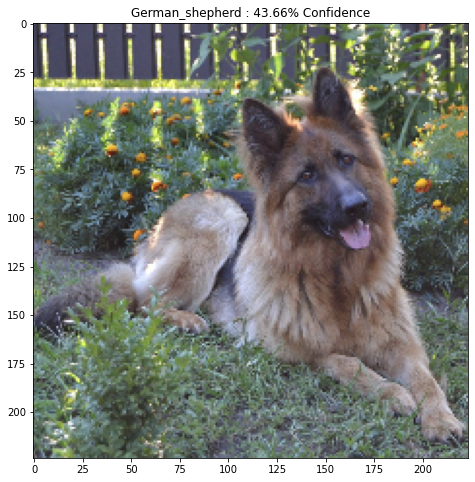

In [8]:
# image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_path = '/home/daryna/Downloads/Telegram Desktop/IMG_4953.JPG'
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw, channels=3)
image = preprocess(image)

predict_and_show(image)

## Blur

In [9]:
loss_object = tf.keras.losses.CategoricalCrossentropy()


In [10]:
def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
#   signed_grad = tf.sign(gradient)
    
  return gradient / tf.math.reduce_max(gradient)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


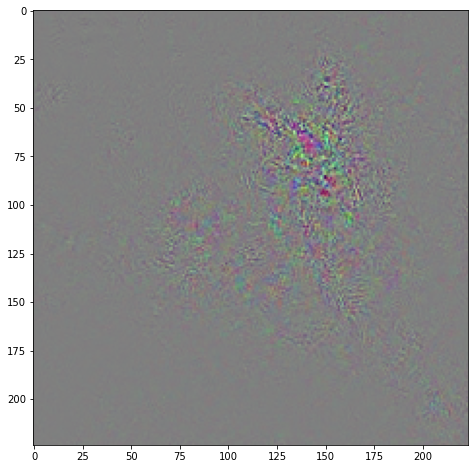

In [11]:
label_idx = pretrained_model.predict(image)
gradient = create_adversarial_pattern(image, label_idx)
plt.imshow(gradient[0]*0.5 + 0.5)

In [12]:
def create_circular_mask(h, w, center=None, radius=None, channels=3):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    mask_d = np.zeros(shape = (h, w, channels), dtype=bool)
    for channel in range(channels):
        mask_d[:,:,channel] = mask
    return mask_d

In [13]:
def find_best_mask(gradient, radius=40, n=100):
    radius=40
    n = 200
    grad_max, mask_blur = 0, None 
    for i in range(n):
        center = random.randint(0, 224), random.randint(0, 224)
        mask = create_circular_mask(224, 224, center, radius)
        grad_cur = np.sum(np.abs(gradient[mask]))
        if grad_cur > grad_max:
            grad_max = grad_cur
            mask_blur = mask
    return mask_blur

In [14]:
def apply_blur(img, mask, factor=3.):
    (h, w) = img.shape[:2]
    kW = int(w / factor)
    kH = int(h / factor)
    # ensure the width of the kernel is odd
    if kW % 2 == 0:
        kW -= 1
    # ensure the height of the kernel is odd
    if kH % 2 == 0:
        kH -= 1
    blurred_img = cv2.GaussianBlur(img, (kW, kH), 0)
    out = np.where(mask, blurred_img, img)
    return out

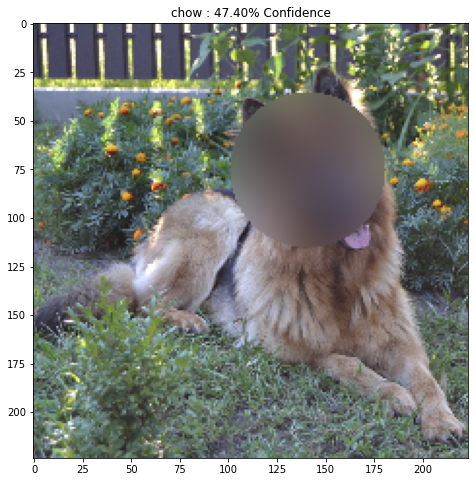

In [15]:
mask_blur = find_best_mask(gradient[0])
image_blur = tf.convert_to_tensor([apply_blur(image[0].numpy(), mask_blur)])

predict_and_show(image_blur)

In [16]:
# # blur_coord = (25, 100, 120, 190)
# def anonymize_face_simple(image, factor=3):
#     # automatically determine the size of the blurring kernel based
#     # on the spatial dimensions of the input image
#     (h, w) = image.shape[:2]
#     kW = int(w / factor)
#     kH = int(h / factor)
#     # ensure the width of the kernel is odd
#     if kW % 2 == 0:
#         kW -= 1
#     # ensure the height of the kernel is odd
#     if kH % 2 == 0:
#         kH -= 1
#     # apply a Gaussian blur to the input image using our computed
#     # kernel size
#     return cv2.GaussianBlur(image, (kW, kH), 0)
# image_new = image.numpy()
# image_new[0, blur_coord[0]:blur_coord[2], blur_coord[1]:blur_coord[3]] = anonymize_face_simple(
#     image_new[0, blur_coord[0]:blur_coord[2], blur_coord[1]:blur_coord[3]])
# image_new = tf.convert_to_tensor(image_new)
# image_probs = pretrained_model.predict(image_new)
# predict_and_show(image_new)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


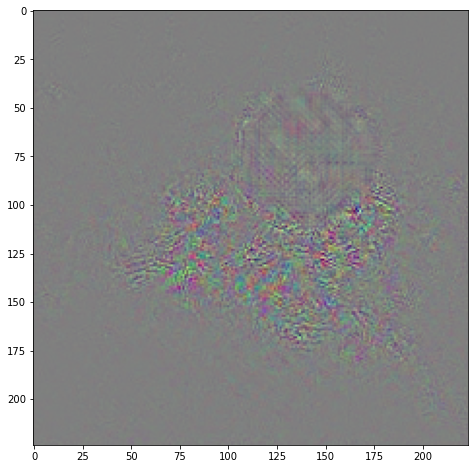

In [17]:
# Get the input label of the image.
# https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
# labrador_retriever_index = 208
# german_shepherd_index = 235
target_index = np.argmax(pretrained_model.predict(image), axis=1)[0]
image_probs = pretrained_model.predict(image_blur)

label = tf.one_hot(target_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image_blur, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

In [18]:
def display_images(image, description):
    _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
    plt.figure()
    plt.imshow(image[0]*0.5+0.5)
    plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
    
    print()
    plt.show()


In [19]:
perturbations.shape

TensorShape([1, 224, 224, 3])

##  Apply FGSM to blurred image

In [20]:
def apply_fgsm(img, mask, correct_idx, eps=0.05, max_iter=10, display_correct=True):
    
    image_probs = pretrained_model.predict(img)
    label = tf.one_hot(correct_idx, image_probs.shape[-1])
    label = tf.reshape(label, (1, image_probs.shape[-1]))
    
    for i in range(max_iter):
        perturbations = create_adversarial_pattern(img, label)
        adv_x = img.numpy()
        adv_x[0][mask] -= eps*perturbations[0][mask]
        adv_x = tf.clip_by_value(adv_x, -1, 1)
        img = tf.convert_to_tensor(adv_x)
        probs = pretrained_model.predict(img)
        label_idx = np.argmax(probs, axis=1)[0]
        label_prob = np.max(probs, axis=1)[0]
        if label_idx == correct_idx:   
            if display_correct:
                display_images(img, f'Epsilon={eps}, step={i+1}')
            return img, label_idx, label_prob, i+1
    return img, label_idx, label_prob, i+1

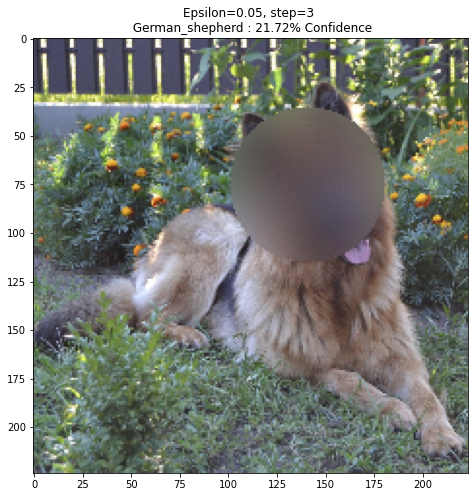

(<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
 array([[[[-0.45808822, -0.42671567, -0.21642154],
          [-0.5125    , -0.5310049 , -0.4154929 ],
          [-0.55877376, -0.5927696 , -0.5453795 ],
          ...,
          [ 0.24313724,  0.27088308, -0.05467981],
          [-0.42249733, -0.38764167, -0.4033088 ],
          [-0.42906135, -0.4369045 , -0.3114143 ]],
 
         [[-0.4588235 , -0.42745095, -0.21407402],
          [-0.50465685, -0.52316177, -0.40992647],
          [-0.54768497, -0.58690065, -0.5555281 ],
          ...,
          [-0.22339344, -0.13672447, -0.3269608 ],
          [-0.44075137, -0.4485945 , -0.32107842],
          [-0.43401694, -0.44186008, -0.3163699 ]],
 
         [[-0.4588235 , -0.42745095, -0.22426468],
          [-0.5067268 , -0.5210918 , -0.4062366 ],
          [-0.5791073 , -0.6010436 , -0.56085134],
          ...,
          [-0.21819663, -0.09999615, -0.23081917],
          [-0.44362748, -0.4492647 , -0.35649508],
          [-0.44837046,

In [21]:
apply_fgsm(image_blur, mask_blur, target_index)

## ImageNet

In [22]:
from tqdm.notebook import tqdm

In [23]:
IMAGENET_PATH = './ILSVRC2012_img_test_v10102019/test'

In [24]:
len(os.listdir(IMAGENET_PATH))

100000

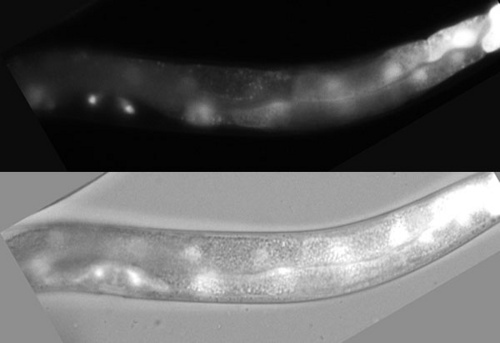

In [25]:
from IPython.display import display, Image
display(Image(filename=(os.path.join(IMAGENET_PATH, 'ILSVRC2012_test_00000001.JPEG'))))

In [26]:
image_blur_masks = dict()
res_all = []
items = sorted(os.listdir(IMAGENET_PATH))[:50000]
pbar = tqdm(total=len(items))

def worker(image_name):
    global image_blur_mask, res_all
    try:
        res = {}
        image_path = os.path.join(IMAGENET_PATH, image_name)
        image_raw = tf.io.read_file(image_path)
        image = tf.image.decode_image(image_raw, channels=3)
        image = preprocess(image)

    #     predict_and_show(image)

        probs = pretrained_model.predict(image)
        label_idx = np.argmax(probs, axis=1)[0]
        label_prob = np.max(probs, axis=1)[0]

        gradient = create_adversarial_pattern(image, probs)
    #     plt.imshow(gradient[0]*0.5 + 0.5)

        mask_blur = find_best_mask(gradient[0])
        image_blur = tf.convert_to_tensor([apply_blur(image[0].numpy(), mask_blur)])
        probs_blur = pretrained_model.predict(image_blur)
        label_idx_blur = np.argmax(probs_blur, axis=1)[0]
        label_prob_blur = np.max(probs_blur, axis=1)[0]

        image_blur_masks[image_name] = mask_blur

        res = {
            'image_name': image_name,

            'initial_label_idx': label_idx,
            'initial_label_prob':label_prob,

            'blurred_label_idx': label_idx_blur,
            'blurred_label_prob': label_prob_blur,
        }
        
        if label_idx == label_idx_blur:
            res_all.append(res)
            return

    #     predict_and_show(image_blur)

        res_fgsm = apply_fgsm(image_blur, mask_blur, label_idx, display_correct=False)

        res.update({
            'fgsm_label_idx': res_fgsm[1],
            'fgsm_prob': res_fgsm[2],
            'fgsm_iter': res_fgsm[3]
#             'correct': label_idx == res_fgsm[1]
        })

        res_all.append(res)
    except Exception as e:
        print(image_name, e)
    finally:
        pbar.update(1)

        

  0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
# from tqdm.contrib.concurrent import process_map
# items = os.listdir(IMAGENET_PATH)
# process_map(worker, items, max_workers=10)

from multiprocessing.pool import ThreadPool as Pool
pool_size = 12  # your "parallelness"

pool = Pool(pool_size)
for item in items:
    pool.apply_async(worker, (item,))
    

pool.close()
pool.join()

In [ ]:
res_all = pd.DataFrame(res_all)
res_all['is_correct'] = None
res_all.loc[res_all['initial_label_idx'] != res_all['blurred_label_idx'], 'is_correct'] = res_all['initial_label_idx']==res_all['fgsm_label_idx']
res_all

In [ ]:
RESULTS_DIR = './results'

In [ ]:
filename_identificator = '1-50000'

In [ ]:
res_all.to_csv(os.path.join(RESULTS_DIR, f'results_{filename_identificator}.csv'), index=False)

In [ ]:
import json
with open(os.path.join(RESULTS_DIR, f'blur_masks_{filename_identificator}.json'), 'w') as f:
    json.dump({k:v.tolist() for k, v in image_blur_masks.items()}, f)